# Draft: Monochromator Fitter

## Load Data

In [27]:
# Get files 
# !ls ~/Downloads/monochromator_local/calib_20250307T222525*

In [2]:
import glob 

regex = '/Users/esteves/Downloads/monochromator_local/calib_20250310T105848/*'
files = sorted(glob.glob(regex))
files

['/Users/esteves/Downloads/monochromator_local/calib_20250310T105848/20250310T105848_20ms_dark.txt',
 '/Users/esteves/Downloads/monochromator_local/calib_20250310T105848/20250310T105848_20ms_wav_10000angs.txt',
 '/Users/esteves/Downloads/monochromator_local/calib_20250310T105848/20250310T105848_20ms_wav_10050angs.txt',
 '/Users/esteves/Downloads/monochromator_local/calib_20250310T105848/20250310T105848_20ms_wav_10100angs.txt',
 '/Users/esteves/Downloads/monochromator_local/calib_20250310T105848/20250310T105848_20ms_wav_10150angs.txt',
 '/Users/esteves/Downloads/monochromator_local/calib_20250310T105848/20250310T105848_20ms_wav_10200angs.txt',
 '/Users/esteves/Downloads/monochromator_local/calib_20250310T105848/20250310T105848_20ms_wav_10250angs.txt',
 '/Users/esteves/Downloads/monochromator_local/calib_20250310T105848/20250310T105848_20ms_wav_10300angs.txt',
 '/Users/esteves/Downloads/monochromator_local/calib_20250310T105848/20250310T105848_20ms_wav_10350angs.txt',
 '/Users/esteves/Do

In [3]:
lineFiles = [f for f in files[1:-1]]

In [4]:
import numpy as np
def get_wav(f):
    mystr = f.split('_')[-1]
    mystr = mystr.split('angs')[0]
    return int(mystr)/10
wav = np.array([get_wav(f) for f in lineFiles])
wav

array([1000., 1005., 1010., 1015., 1020., 1025., 1030., 1035., 1040.,
       1045., 1050., 1055., 1060., 1065., 1070., 1075., 1080., 1085.,
       1090., 1095., 1100.,  300.,  305.,  310.,  315.,  320.,  325.,
        330.,  335.,  340.,  345.,  350.,  355.,  360.,  365.,  370.,
        375.,  380.,  385.,  390.,  395.,  400.,  405.,  410.,  415.,
        420.,  425.,  430.,  435.,  440.,  445.,  450.,  455.,  460.,
        465.,  470.,  475.,  480.,  485.,  490.,  495.,  500.,  505.,
        510.,  515.,  520.,  525.,  530.,  535.,  540.,  545.,  550.,
        555.,  560.,  565.,  570.,  575.,  580.,  585.,  590.,  595.,
        600.,  605.,  610.,  615.,  620.,  625.,  630.,  635.,  640.,
        645.,  650.,  655.,  660.,  665.,  670.,  675.,  680.,  685.,
        690.,  695.,  700.,  705.,  710.,  715.,  720.,  725.,  730.,
        735.,  740.,  745.,  750.,  755.,  760.,  765.,  770.,  775.,
        780.,  785.,  790.,  795.,  800.,  805.,  810.,  815.,  820.,
        825.,  830.,

In [5]:
def read_file(f):
    w = np.genfromtxt(f)[:,0]
    c = np.genfromtxt(f)[:,1]
    return w,c

In [6]:
ix = 19
w, dark = read_file(files[0])
w, c = read_file(files[ix])

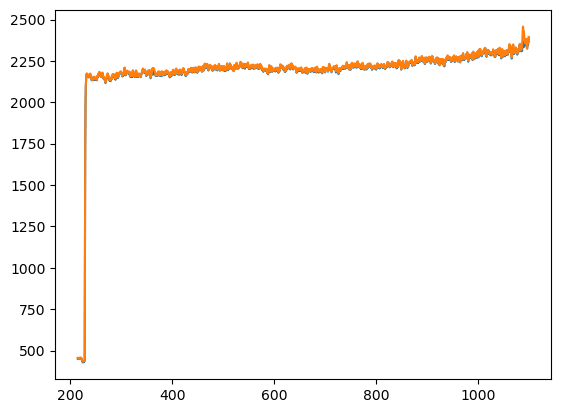

In [7]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
plt.plot(w,dark)
plt.plot(w,c)

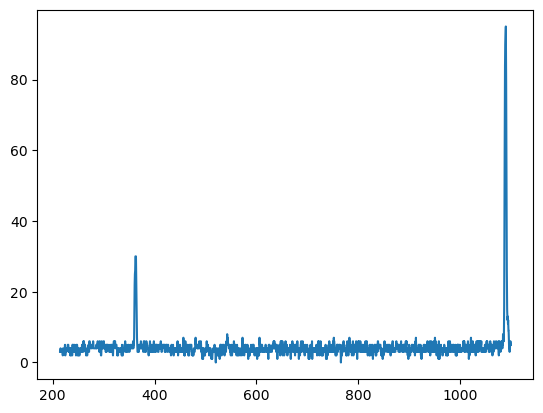

In [8]:
plt.plot(w,c-dark)

In [9]:
intensities = c-dark
x_data = w

In [10]:
from scipy.signal import find_peaks, peak_widths

distance = 20
height = 200
peaks, properties = find_peaks(intensities,
                               height=height,
                               distance=distance)
results_half = peak_widths(intensities, peaks, rel_height=0.5)
peak_x_positions = x_data[peaks]
peak_intensities = intensities[peaks]

In [11]:
results_half

(array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64))

In [12]:
dp = int(results_half[0])
results_b = peak_widths(intensities, peaks, rel_height=0.91)
dh = results_b[1]

TypeError: only length-1 arrays can be converted to Python scalars

In [13]:
peak_x_positions

array([], dtype=float64)

In [14]:
ilow = int(peaks[0]-2.5*dp)
ihigh = int(peaks[0]+2.5*dp)
mask = intensities[ilow:ihigh]<dh
c = np.polyfit(x_data[ilow:ihigh][mask], intensities[ilow:ihigh][mask],1)
bg = np.polyval(c,x_data[ilow:ihigh])
pointsH = bg[ihigh-peaks[0]] - peak_intensities*3/100

plt.scatter(x_data[ilow:ihigh], intensities[ilow:ihigh], color='k', label='Line Data')
plt.plot(x_data[ilow:ihigh], bg, color='firebrick', label='Background')
plt.axvline(wav[ix], ls='--', color='grey', label='Commanded wav')
plt.plot(peak_x_positions, pointsH, 'rx', markersize=8, label='Peak')
plt.legend()
plt.xlabel("Wavelength [nm]")
plt.ylabel("Counts [ADU]")

IndexError: index 0 is out of bounds for axis 0 with size 0

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit

# Define a simple Gaussian function with constant offset
def gauss(x, amp, mu, sigma, offset):
    return amp * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + offset

class monoLineFinder:
    """
    Class to analyze a single peak in a spectrum (e.g. from a monochromator).
    It locates the main peak, estimates the background via a linear fit,
    and provides methods to visualize the result. Now also fits a Gaussian line.
    """
    
    def __init__(self, x_data, intensities,
                 distance=20, height=2500,
                 rel_height_bg=0.91, rel_height_peak=0.5):
        """
        Parameters
        ----------
        x_data : array-like
            Wavelength axis data. (E.g. 300 nm to 1100 nm)
        intensities : array-like
            Measured intensities at each wavelength.
        distance : float
            Minimum horizontal distance (in array indices) between peaks
            passed to find_peaks().
        height : float
            Minimum peak height passed to find_peaks().
        rel_height_bg : float
            'rel_height' passed to peak_widths() for identifying the background region.
            (Typically near 0.9 or 0.95.)
        rel_height_peak : float
            'rel_height' for the main peak half‐width measurement. Typically 0.5.
        """
        self.x_data = np.arange(x_data.size, dtype=int)
        self.intensities = np.array(intensities, dtype=float)
        self.distance = distance
        self.height = height
        self.rel_height_bg = rel_height_bg
        self.rel_height_peak = rel_height_peak
        
        # Analysis results
        self.peaks = None
        self.peak_x_positions = None
        self.peak_intensities = None
        self.bg_poly = None       # (slope, intercept) from np.polyfit
        self.bg_xrange = None     # x values used for background modeling
        self.bg_vals = None       # background intensities from polyfit
        self.ilow = None
        self.ihigh = None
        self.dp = None
        self.dh = None
        self.found_peak_index = None  # single peak index if found

        # Gaussian fit results
        self.gauss_params = None  # (amp, center, sigma, offset)
        self.gauss_cov = None     # covariance matrix from curve_fit

        # Additional centroid results
        self.parabola_vertex = None
        self.moment_center = None

    def find_line(self):
        """
        1. Finds a single main peak via find_peaks()
        2. Gets the peak widths
        3. Identifies a window around the peak
        4. Fits a linear background to points below a certain threshold
        5. Stores relevant results in object attributes
        """
        # --- 1. Find peak(s) ---
        peaks, properties = find_peaks(
            self.intensities, height=self.height, distance=self.distance
        )
        if len(peaks) == 0:
            raise ValueError("No peaks found with the given 'height' and 'distance' constraints.")

        # We'll assume there's only one main peak. If multiple, pick the highest.
        main_peak_idx = peaks[np.argmax(self.intensities[peaks])]
        self.peaks = [main_peak_idx]
        
        # Store the single peak position and intensity
        self.peak_x_positions = self.x_data[main_peak_idx]
        self.peak_intensities = self.intensities[main_peak_idx]
        self.found_peak_index = main_peak_idx
        
        # --- 2. Get peak width at rel_height=0.5 ---
        results_half = peak_widths(
            self.intensities, [main_peak_idx], rel_height=self.rel_height_peak
        )
        self.dp = int(results_half[0])  # approximate half‐width in array indices
        
        # --- 3. Identify background region at rel_height_bg ~ 0.91 ---
        results_bg = peak_widths(
            self.intensities, [main_peak_idx], rel_height=self.rel_height_bg
        )
        # results_bg[1][0] is the intensity “height” at that fraction
        self.dh = results_bg[1][0]

        # We'll define a ±2.5*dp window around the peak for background fitting
        self.ilow = int(main_peak_idx - 2.5 * self.dp)
        self.ihigh = int(main_peak_idx + 2.5 * self.dp)
        self.ilow = max(self.ilow, 0)
        self.ihigh = min(self.ihigh, len(self.x_data))
        
        xwin = self.x_data[self.ilow : self.ihigh]
        ywin = self.intensities[self.ilow : self.ihigh]

        # Use only points below the threshold "dh" to fit the background
        mask = ywin < self.dh
        if not np.any(mask):
            # If everything is above dh, fallback to using them all
            mask = np.ones_like(xwin, dtype=bool)
        
        # --- 4. Fit linear background ---
        c = np.polyfit(xwin[mask], ywin[mask], 1)  # slope, intercept
        self.bg_poly = c
        self.bg_xrange = xwin
        self.bg_vals = np.polyval(c, xwin)

        return main_peak_idx

    def fit_gaussian_line(self):
        """
        Fits a single Gaussian (amp, center, sigma, offset) to the
        spectral data in the window around the found peak.

        Returns
        -------
        popt : array
            Best-fit parameters [amplitude, center, sigma, offset].
        pcov : 2D array
            The estimated covariance of popt.
        """
        if self.found_peak_index is None:
            raise ValueError("No peak found. Run find_line() first.")

        # Window around peak
        i1, i2 = self.ilow, self.ihigh
        y_win = self.intensities[i1 : i2].copy()
        x_win = np.linspace(i1, i2, y_win.size)
        
        # Initial guesses:
        # amplitude ~ peak height minus local background
        if self.bg_poly is not None:
            local_bg = np.polyval(self.bg_poly, self.peak_x_positions)
            guess_amp = self.peak_intensities - local_bg
            y_win -= np.polyval(self.bg_poly, x_win)
        else:
            guess_amp = self.peak_intensities
        
        guess_mu = self.peaks[0]
        guess_sigma = max(self.dp / 2.35482, 1.0)  # dp is in array indices

        p0 = [guess_amp, guess_mu, guess_sigma, 0.0]

        # Fit using curve_fit
        popt, pcov = curve_fit(gauss, x_win, y_win, p0=p0)

        self.gauss_params = popt
        self.gauss_cov = pcov
        return popt, pcov

    def measure_centroids(self):
        """
        Computes two additional centroid positions for the main peak:
         1. Parabola vertex within ±FWHM
         2. First moment (center of mass) within ±2.5*FWHM

        Stores the results as:
          self.parabola_vertex
          self.moment_center

        Returns
        -------
        parabola_vertex : float
            The x position of the parabola vertex fit in ±FWHM region.
        moment_center : float
            The x position of the center-of-mass in ±2.5*FWHM region.
        """
        if self.found_peak_index is None:
            raise ValueError("No peak found. Run find_line() first.")

        peak_idx = self.found_peak_index
        fwhm_pts = self.dp  # approximate FWHM in array indices

        # -- 1) Parabola Vertex in ±FWHM window --
        half_win = fwhm_pts
        p_low = max(peak_idx - half_win, 0)
        p_high = min(peak_idx + half_win, len(self.x_data))

        x_para = self.x_data[p_low : p_high]
        y_para = self.intensities[p_low : p_high]
        if len(x_para) < 3:
            # fallback if the window is too narrow
            self.parabola_vertex = self.peak_x_positions
        else:
            # fit parabola
            coeffs = np.polyfit(x_para, y_para, 2)  # a, b, c
            a, b, c = coeffs
            if abs(a) < 1e-12:
                # degenerate (not really a parabola)
                self.parabola_vertex = self.peak_x_positions
            else:
                vertex_x = -b / (2*a)
                self.parabola_vertex = vertex_x

        # -- 2) First Moment in ±2.5*FWHM window --
        wide_win = int(2.5 * fwhm_pts)
        m_low = max(peak_idx - wide_win, 0)
        m_high = min(peak_idx + wide_win, len(self.x_data))

        x_mom = self.x_data[m_low : m_high]
        y_mom = self.intensities[m_low : m_high]
        total_flux = np.sum(y_mom)
        if total_flux == 0 or len(x_mom) == 0:
            # fallback
            self.moment_center = self.peak_x_positions
        else:
            self.moment_center = np.sum(x_mom * y_mom) / total_flux

        return self.parabola_vertex, self.moment_center
    
    def plot_line(self, commanded_wav=[None,None], ax=None):
        """
        Plot the data window around the main peak, the fitted background,
        and indicate the identified peak position.
        
        Parameters
        ----------
        commanded_wav : float or None
            If provided, draws a vertical dashed line for the 'commanded' wavelength.
        ax : matplotlib Axes object or None
            If None, create a new figure/axes; otherwise draw on the provided axes.
        """
        if self.found_peak_index is None:
            raise ValueError("Run find_line() before plotting.")

        if ax is None:
            fig, ax = plt.subplots(figsize=(6,4))

        # Window around the peak
        i1, i2 = self.ilow, self.ihigh
        xx = self.x_data[i1 : i2]
        yy = self.intensities[i1 : i2]

        # Fitted background
        bg = self.bg_vals

        ax.scatter(xx, yy, color='k', label='Line Data')
        ax.plot(xx, bg, color='firebrick', label='Background')
        ax.plot(xx, gauss(xx, *self.gauss_params)+bg, color='k', label='Gaussian Fit')
        
        if commanded_wav[0] is not None:
            ax.axvline(commanded_wav[1], ls='--', color='grey', label='Commanded wav')
            ax.set_title(r"Monochromator $\lambda=%i nm$"%commanded_wav[0])
        
        # Mark the main peak
        ax.plot(self.peak_x_positions, self.peak_intensities,
                'rx', markersize=8, label='Peak')
        
        # Mark the centroid positions
        ax.plot(self.parabola_vertex, self.peak_intensities, color='k' ,marker='x', ls='--', label='Parabola Vertex')
        ax.plot(self.moment_center, self.peak_intensities, color='g', marker='x', ls='--', label='Moment Center')

        ax.legend()
        ax.set_xlabel("Pixels")
        ax.set_ylabel("Counts [ADU]")
        # ax.set_title("monoLineFinder Result")
        fig.tight_layout()
        return fig


In [16]:
from scipy.interpolate import interp1d
pixel = np.arange(x_data.size, dtype=int)
# specCoefs = np.polyfit(x_data,pixel,5)
wav2pixel = interp1d(x_data, pixel)
pixel2wav = interp1d(pixel, x_data)

In [17]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

peaks, vertex, cen = [], [], []
heights = []
trues = []

# Create one PDF file that will collect all figures
with PdfPages("monochromator_peaks_20250310T105848.pdf") as pdf:
    for i in range(wav.size):
        wavelength = wav[i]
        f  = lineFiles[i]
        print(i, f)
        x_data, intensities = read_file(f)
        tp = wav2pixel(wavelength)

        finder = monoLineFinder(x_data, intensities-dark,
                                distance=1100, height=50,
                                rel_height_bg=0.91, rel_height_peak=0.5)
    
        p = finder.find_line()
        v, c = finder.measure_centroids()
        popt, pcov = finder.fit_gaussian_line()
    
        # This returns a matplotlib Figure
        fig = finder.plot_line(commanded_wav=[wavelength, tp])

        # Save the current figure to the PDF
        pdf.savefig(fig)
        
        # Good practice to close the figure so as not to clutter memory
        plt.close(fig)
    
        # Collect numeric data for later usage
        peaks.append(p)
        vertex.append(v)
        cen.append(c)
        trues.append(tp)
        heights.append(finder.peak_intensities)

# Convert to arrays if desired
peaks = np.array(peaks)
vertex = np.array(vertex)
cen = np.array(cen)
trues = np.array(trues)
heights = np.array(heights)

0 /Users/esteves/Downloads/monochromator_local/calib_20250310T105848/20250310T105848_20ms_wav_10000angs.txt


/var/folders/9w/7v0prkkd4v316l4bdkm114c00000gq/T/ipykernel_17349/3450673335.py:94: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.dp = int(results_half[0])  # approximate half‐width in array indices


1 /Users/esteves/Downloads/monochromator_local/calib_20250310T105848/20250310T105848_20ms_wav_10050angs.txt
2 /Users/esteves/Downloads/monochromator_local/calib_20250310T105848/20250310T105848_20ms_wav_10100angs.txt
3 /Users/esteves/Downloads/monochromator_local/calib_20250310T105848/20250310T105848_20ms_wav_10150angs.txt
4 /Users/esteves/Downloads/monochromator_local/calib_20250310T105848/20250310T105848_20ms_wav_10200angs.txt
5 /Users/esteves/Downloads/monochromator_local/calib_20250310T105848/20250310T105848_20ms_wav_10250angs.txt
6 /Users/esteves/Downloads/monochromator_local/calib_20250310T105848/20250310T105848_20ms_wav_10300angs.txt
7 /Users/esteves/Downloads/monochromator_local/calib_20250310T105848/20250310T105848_20ms_wav_10350angs.txt
8 /Users/esteves/Downloads/monochromator_local/calib_20250310T105848/20250310T105848_20ms_wav_10400angs.txt
9 /Users/esteves/Downloads/monochromator_local/calib_20250310T105848/20250310T105848_20ms_wav_10450angs.txt
10 /Users/esteves/Downloads/

Text(0.5, 1.0, 'Monochromator Scan (LDLS)')

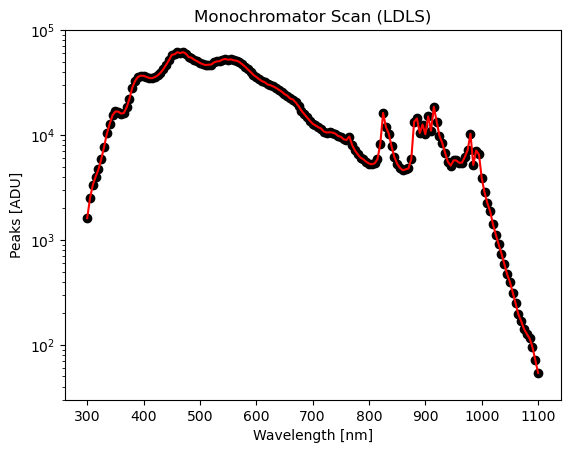

In [25]:
ix = np.argsort(wav)
plt.scatter(wav, heights, color='k')
plt.plot(wav[ix], heights[ix], color='r')
plt.xlabel("Wavelength [nm]")
plt.ylabel("Peaks [ADU]")
plt.yscale("log")
plt.ylim(3e1,1e5)
plt.title("Monochromator Scan (LDLS)")

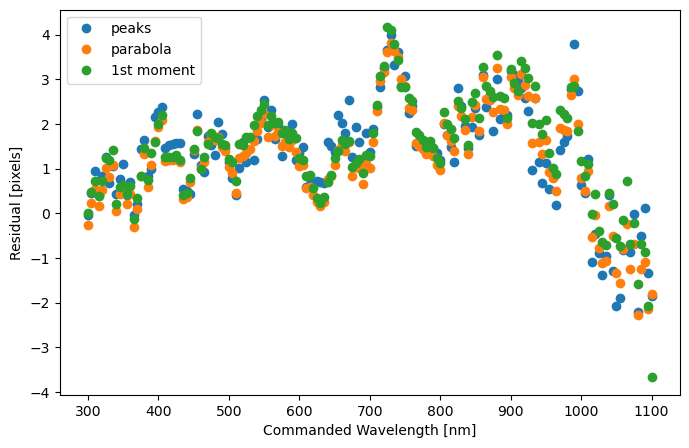

In [19]:

plt.figure(figsize=(8,5))

methods = ['peaks','parabola','1st moment']
for i, x in enumerate([peaks, vertex, cen]):
    plt.plot(wav, x-trues, 'o', label=methods[i])
    plt.ylabel('Residual [pixels]')
    plt.xlabel('Commanded Wavelength [nm]')
    plt.legend()

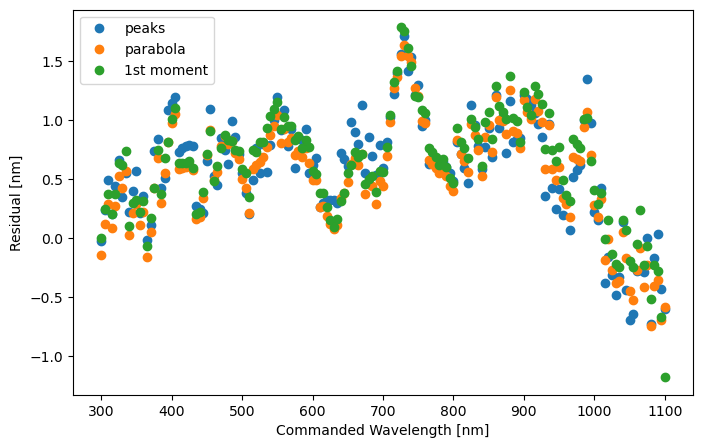

In [20]:
methods = ['peaks','parabola','1st moment']
plt.figure(figsize=(8,5))
for i, x in enumerate([peaks, vertex, cen]):
    res = pixel2wav(x)-wav
    plt.plot(wav, res, 'o', label=methods[i])
    plt.ylabel('Residual [nm]')
    plt.xlabel('Commanded Wavelength [nm]')
    plt.legend()

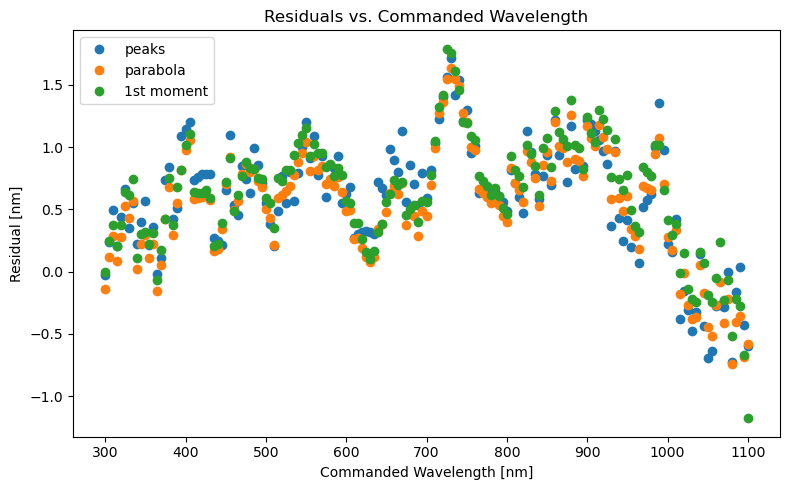

/var/folders/9w/7v0prkkd4v316l4bdkm114c00000gq/T/ipykernel_17349/1800583301.py:44: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freqs_pos, mag_pos, label=methods[i])


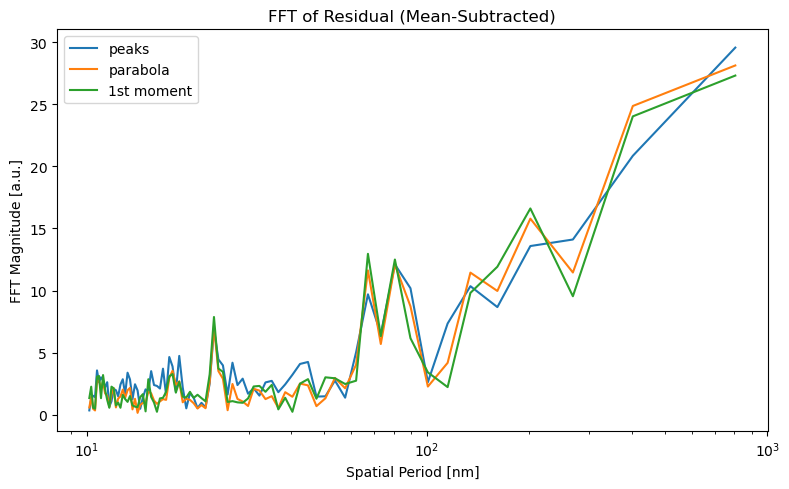

In [27]:
import numpy as np
import matplotlib.pyplot as plt

methods = ['peaks', 'parabola', '1st moment']
residual_sets = [peaks, vertex, cen]  # each is an array of the same length as wav

# 1) Plot the residual in the time (or nm) domain
plt.figure(figsize=(8,5))
for i, x in enumerate(residual_sets):
    res = pixel2wav(x) - wav
    plt.plot(wav, res, 'o', label=methods[i])
plt.ylabel('Residual [nm]')
plt.xlabel('Commanded Wavelength [nm]')
plt.legend()
plt.title("Residuals vs. Commanded Wavelength")
plt.tight_layout()
plt.show()

# 2) Plot the Fourier Transform of each residual set
plt.figure(figsize=(8,5))

# Check that wav is uniformly spaced
dw = wav[1] - wav[0]  # spacing in nm (must be constant)
N = len(wav)

for i, x in enumerate(residual_sets):
    # Compute the residual
    res = pixel2wav(x) - wav
    
    # Subtract the mean (remove DC)
    res_no_dc = res - np.mean(res)
    
    # FFT
    F = np.fft.fft(res_no_dc)
    
    # Frequency axis: cycles per nm
    freqs = np.fft.fftfreq(N, d=dw)  # This will run from negative to positive frequencies
    
    # If you only want to plot the positive frequencies:
    half = N // 2
    freqs_pos = freqs[:half]
    mag_pos = np.abs(F)[:half]
    
    plt.plot(1/freqs_pos, mag_pos, label=methods[i])

plt.xlabel("Spatial Period [nm]")
plt.ylabel("FFT Magnitude [a.u.]")
plt.title("FFT of Residual (Mean-Subtracted)")
plt.legend()
plt.xscale('log')
plt.tight_layout()
plt.show()


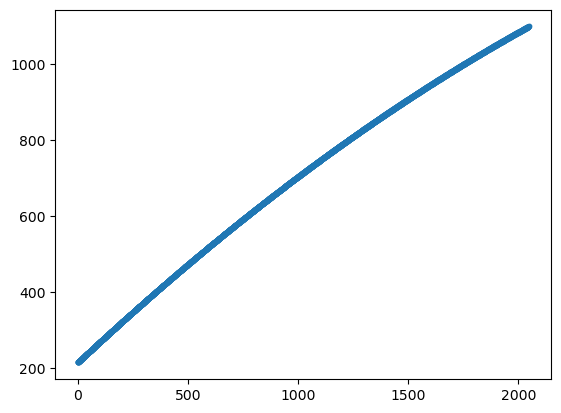

In [22]:
plt.scatter(np.arange(w.size), w, s=10)
# plt.xlim(500,550)